<a href="https://colab.research.google.com/github/2000siddharth/web_scraping_classification/blob/master/naivebayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**OBJECTIVE :**

**Classifying videos (based on description) in following 10** categories  



*   Travel Blogs
*   Science and Technology
*   Movies
*   Food
*   Arts
*   Tutorial
*   History
*   Music
*   Fashion
*   Vlog

Here we use the **Naive Bayes** Approach for classification.

Importing all necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import sqlite3
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from prettytable import PrettyTable

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import hstack

In [0]:
df = pd.read_csv('combined_youtube4.csv')

**Data Preprocessing**

In [0]:
def cleaner(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can't", 'can not', phrase)
  
  # general
    phrase = re.sub(r"n\'t"," not", phrase)
    phrase = re.sub(r"\'re'"," are", phrase)
    phrase = re.sub(r"\'s"," is", phrase)
    phrase = re.sub(r"\'ll"," will", phrase)
    phrase = re.sub(r"\'d"," would", phrase)
    phrase = re.sub(r"\'t"," not", phrase)
    phrase = re.sub(r"\'ve"," have", phrase)
    phrase = re.sub(r"\'m"," am", phrase)
    
    return phrase

In [7]:
from bs4 import BeautifulSoup
from tqdm import tqdm
import re

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
stop = set(stopwords.words('english'))
len(stop)

179

In [9]:
cleaned_title = []

for sentance in tqdm(df['title'].values):
    sentance = str(sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = cleaner(sentance)
    sentance = re.sub(r'[?|!|\'|"|#|+]', r'', sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    cleaned_title.append(sentance.strip())

100%|██████████| 10275/10275 [00:03<00:00, 3312.74it/s]


In [10]:
cleaned_description = []

for sentance in tqdm(df['description'].values):
    sentance = str(sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = cleaner(sentance)
    sentance = re.sub(r'[?|!|\'|"|#|+]', r'', sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    cleaned_description.append(sentance.strip())

 31%|███       | 3192/10275 [00:01<00:02, 3195.34it/s]/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 10275/10275 [00:03<00:00, 3129.90it/s]


In [11]:
df['title'] = cleaned_title

df['description'] = cleaned_description
df.head()

,video_id,title,description,category
0,https://www.youtube.com/watch?v=J8XJjkA5NuQ,dr p j abdul kalam lecture series iit bombay,techfest iit bombay presents dr p j abdul kala...,tutorial
1,https://www.youtube.com/watch?v=C31hcftHBIk,lecture laa ke nachhatar gill full video song ...,angel records presents new punjabi song lectur...,tutorial
2,https://www.youtube.com/watch?v=Xn7KWR9EOGQ,basics stock market beginners lecture ca racha...,get lectures new website opportunity learn con...,tutorial
3,https://www.youtube.com/watch?v=FPaByTt1Yws,musique classique pour la lecture de mozart ch...,musique classique pour la lecture de mozart ch...,tutorial
4,https://www.youtube.com/watch?v=ViyG77Bca4I,pte retell lecture january february predicted ...,practice session covers pte retell lecture rea...,tutorial


Here we **Label Encode the category values.**

First we shall use the **title** for prediction

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

labels = LabelEncoder()
df['categoryid'] = labels.fit_transform(df['category'])

X = df['title']
y = df['categoryid']

Using Stratified Shuffle Split to ensure equal representation of classes in train and test sets

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

In [14]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
sss.get_n_splits(X, y)

10

In [0]:
for train_index, test_index in sss.split(X, y):
#    print("TRAIN:", train_index, "TEST:", test_index)
    X_Train, X_test = X[train_index], X[test_index]
    y_Train, y_test = y[train_index], y[test_index]  

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_cross, y_train, y_cross = train_test_split(X_Train, y_Train, random_state=0, stratify=y_Train, test_size=0.1)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

**Using the Count vectorizer**

In [0]:
count_vect = CountVectorizer()
count_vect.fit(X_train)
X_train_counts = count_vect.transform(X_train)
X_cross_counts = count_vect.transform(X_cross)
X_test_counts = count_vect.transform(X_test)

**Naive Bayes using BOW**

**Hyperparameter Tuning (alpha)**

In [0]:
alpha_set=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
Train_AUC_BOW = []
CrossVal_AUC_BOW = []
for i in alpha_set:
  naive_b=MultinomialNB(alpha=i)
  naive_b.fit(X_train_counts, y_train)
  Train_y_pred =  naive_b.predict_proba(X_train_counts)[0:,]
  Train_AUC_BOW.append(roc_auc_score(y_train,Train_y_pred, multi_class='ovr'))
  CrossVal_y_pred =  naive_b.predict_proba(X_cross_counts)[0:,]
  CrossVal_AUC_BOW.append(roc_auc_score(y_cross,CrossVal_y_pred, multi_class='ovr'))

In [0]:
from numpy import math
Alpha_set=[]
for i in range(len(alpha_set)):
  Alpha_set.append(math.log(alpha_set[i]))

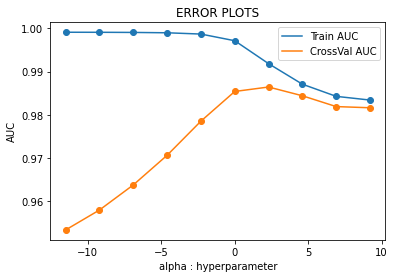

In [0]:
plt.plot(Alpha_set, Train_AUC_BOW, label='Train AUC')
plt.scatter(Alpha_set, Train_AUC_BOW)
plt.plot(Alpha_set, CrossVal_AUC_BOW, label='CrossVal AUC')
plt.scatter(Alpha_set, CrossVal_AUC_BOW)
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_alpha=alpha_set[CrossVal_AUC_BOW.index(max(CrossVal_AUC_BOW))]
print(optimal_alpha)

10


In [0]:
Classifier1=MultinomialNB(alpha=optimal_alpha)
Classifier1.fit(X_train_counts, y_train)

MultinomialNB(alpha=10, class_prior=None, fit_prior=True)

In [0]:
auc_train_bow = roc_auc_score(y_train,Classifier1.predict_proba(X_train_counts)[0:,], multi_class='ovr')
print ("AUC for Train set", auc_train_bow)

auc_test_bow = roc_auc_score(y_test,Classifier1.predict_proba(X_test_counts)[0:,], multi_class='ovr')
print ("AUC for Test set",auc_test_bow)

AUC for Train set 0.9918285852858425
AUC for Test set 0.9865310385955693


**Confusion Matrix**

In [0]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(y_train,Classifier1.predict(X_train_counts))
print (Train_mat)

Confusion Matrix of Train Data
[[675   1   5   2  33  10   9   2  10   7]
 [  4 565   2   3   1   2   5   2 158   2]
 [  1   1 722   0   4   1   1   4   2  12]
 [  3   2   3 640  13   6   1   5   4   2]
 [  1   0   1   1 736   3   2   4   0   0]
 [  1   2   2   2  12 759   1   1   1   2]
 [  7   2   0   1  10   4 658   0   5   3]
 [  0   0   8   2   0   0   0 717   1   7]
 [  8  71   3   3   7  11   8   6 672  10]
 [  0   1   8   1  20   3   1  14   7 663]]


In [0]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(y_test,Classifier1.predict(X_test_counts))
print (Test_mat)

Confusion Matrix of Test Data
[[171   3   3   6   9   3   2   5   1   7]
 [  1 115   0   1   2   2   2   1  79   3]
 [  0   0 198   0   3   2   0   2   1   2]
 [  0   3   1 173   6   2   0   2   1   0]
 [  1   0   0   0 204   1   0   2   0   0]
 [  0   0   2   2   4 203   1   2   1   3]
 [  4   0   1   1   2   0 184   0   0   0]
 [  0   1   3   0   0   0   0 197   0   3]
 [  1  48   2   3   0   5   4   3 152   4]
 [  0   1   2   1   6   1   1   4   3 180]]


In [0]:
from sklearn.metrics import accuracy_score, log_loss, f1_score

preds = Classifier1.predict(X_test_counts)

acc = accuracy_score(y_test, preds)

f1 = f1_score(y_test, preds, average='macro')

print ('Accuracy is : ', acc)
print ('F1 Score is :', f1)

Accuracy is :  0.864720194647202
F1 Score is : 0.8650669728842797


In [0]:
c = np.unique(df['category'])

In [0]:
recall = np.diag(Test_mat) / np.sum(Test_mat, axis = 1)
precision = np.diag(Test_mat) / np.sum(Test_mat, axis = 0)

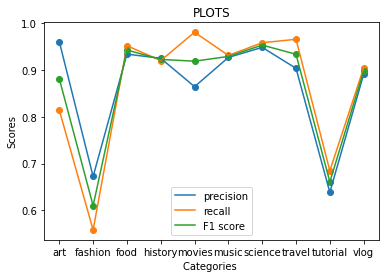

In [0]:
plt.plot(c,precision, label='precision')
plt.scatter(c,precision)
plt.plot(c,recall, label='recall')
plt.scatter(c,recall)
plt.plot(c,2*(precision * recall) / (precision + recall) , label='F1 score')
plt.scatter(c,2*(precision * recall) / (precision + recall))
plt.legend()
plt.xlabel("Categories ")
plt.ylabel("Scores")
plt.title("PLOTS")

plt.show()

**Observations**
  1. Optimal value of alpha is 10
  2. Classifier works well with accuracy of 0.86472019


**Now we shall try to perform the same operation by using sampling methods to ensure equal class-representation**

In [18]:
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [21]:
smote = SMOTE('minority')
X_sm, y_sm = smote.fit_sample(X_train_counts,y_train)
X_sm.shape, y_sm.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((7518, 11539), (7518,))

In [22]:
smote = SMOTE('minority')

X_test_sm, y_test_sm = smote.fit_sample(X_test_counts,y_test)
X_test_sm.shape, y_test_sm.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((2089, 11539), (2089,))

**MNB on balanced dataset using SMOTE**

In [0]:
alpha_set=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
Train_AUC_BOW = []
CrossVal_AUC_BOW = []
for i in alpha_set:
  naive_b=MultinomialNB(alpha=i)
  naive_b.fit(X_sm, y_sm)
  Train_y_pred =  naive_b.predict_proba(X_sm)[0:,]
  Train_AUC_BOW.append(roc_auc_score(y_sm,Train_y_pred, multi_class='ovr'))
  CrossVal_y_pred =  naive_b.predict_proba(X_cross_counts)[0:,]
  CrossVal_AUC_BOW.append(roc_auc_score(y_cross,CrossVal_y_pred, multi_class='ovr'))

In [0]:
from numpy import math
Alpha_set=[]
for i in range(len(alpha_set)):
  Alpha_set.append(math.log(alpha_set[i]))

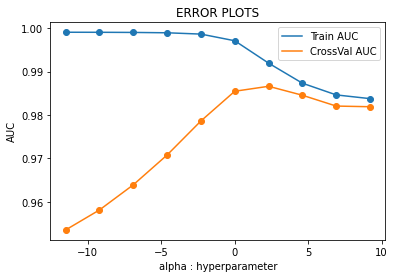

In [0]:
plt.plot(Alpha_set, Train_AUC_BOW, label='Train AUC')
plt.scatter(Alpha_set, Train_AUC_BOW)
plt.plot(Alpha_set, CrossVal_AUC_BOW, label='CrossVal AUC')
plt.scatter(Alpha_set, CrossVal_AUC_BOW)
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_alpha=alpha_set[CrossVal_AUC_BOW.index(max(CrossVal_AUC_BOW))]
print(optimal_alpha)

10


In [0]:
Classifier2=MultinomialNB(alpha=optimal_alpha)
Classifier2.fit(X_sm, y_sm)

MultinomialNB(alpha=10, class_prior=None, fit_prior=True)

In [0]:
auc_train_bow = roc_auc_score(y_sm,Classifier2.predict_proba(X_sm)[0:,], multi_class='ovr')
print ("AUC for Train set", auc_train_bow)

auc_test_bow = roc_auc_score(y_test_sm,Classifier2.predict_proba(X_test_sm)[0:,], multi_class='ovr')
print ("AUC for Test set",auc_test_bow)

AUC for Train set 0.9919531387311531
AUC for Test set 0.9867716253665293


**Confusion Matrix**

In [0]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(y_sm,Classifier2.predict(X_sm))
print (Train_mat)

Confusion Matrix of Train Data
[[673   1   5   7  33  10   9   2   7   7]
 [  4 564   2   5   1   2   5   2 157   2]
 [  1   1 722   1   4   1   1   4   1  12]
 [  3   2   3 764  13   4   1   5   2   2]
 [  1   0   1   1 736   3   2   4   0   0]
 [  1   2   2   3  12 759   1   1   0   2]
 [  7   2   0   1  10   4 658   0   5   3]
 [  0   0   8   2   0   0   0 717   1   7]
 [  8  70   3   8   7  11   8   6 668  10]
 [  0   1   8   5  20   3   1  14   3 663]]


In [0]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(y_test_sm,Classifier2.predict(X_test_sm))
print (Test_mat)

Confusion Matrix of Test Data
[[171   3   3   6   9   3   2   5   1   7]
 [  1 114   0   4   2   2   1   1  78   3]
 [  0   0 198   1   3   2   0   2   0   2]
 [  0   2   1 209   6   2   0   1   1   0]
 [  1   0   0   0 204   1   0   2   0   0]
 [  0   0   2   3   4 202   1   2   1   3]
 [  4   0   1   1   2   0 184   0   0   0]
 [  0   1   3   1   0   0   0 196   0   3]
 [  1  46   2   7   0   5   4   3 150   4]
 [  0   1   2   5   6   0   1   4   0 180]]


In [0]:
from sklearn import metrics
print(metrics.classification_report(y_test_sm,Classifier2.predict(X_test_sm), target_names=df['category'].unique()))

              precision    recall  f1-score   support

    tutorial       0.96      0.81      0.88       210
     science       0.68      0.55      0.61       206
        vlog       0.93      0.95      0.94       208
        food       0.88      0.94      0.91       222
     fashion       0.86      0.98      0.92       208
      travel       0.93      0.93      0.93       218
       music       0.95      0.96      0.96       192
      movies       0.91      0.96      0.93       204
     history       0.65      0.68      0.66       222
         art       0.89      0.90      0.90       199

    accuracy                           0.87      2089
   macro avg       0.87      0.87      0.86      2089
weighted avg       0.86      0.87      0.86      2089



In [0]:
from sklearn import metrics
print(metrics.classification_report(y_test,Classifier2.predict(X_test_counts), target_names=df['category'].unique()))

              precision    recall  f1-score   support

    tutorial       0.96      0.81      0.88       210
     science       0.68      0.55      0.61       206
        vlog       0.93      0.95      0.94       208
        food       0.86      0.93      0.90       188
     fashion       0.86      0.98      0.92       208
      travel       0.93      0.93      0.93       218
       music       0.95      0.96      0.96       192
      movies       0.91      0.96      0.93       204
     history       0.65      0.68      0.66       222
         art       0.89      0.90      0.90       199

    accuracy                           0.86      2055
   macro avg       0.86      0.87      0.86      2055
weighted avg       0.86      0.86      0.86      2055



In [0]:
preds = Classifier2.predict(X_test_counts)

acc = accuracy_score(y_test, preds)

f1 = f1_score(y_test, preds, average='macro')

print ('Accuracy is : ', acc)
print ('F1 Score is :', f1)

Accuracy is :  0.8632603406326034
F1 Score is : 0.862754046728918


In [0]:
recall = np.diag(Test_mat) / np.sum(Test_mat, axis = 1)
precision = np.diag(Test_mat) / np.sum(Test_mat, axis = 0)

**Bernoulli Naive Bayes on Sampled Data**

In [0]:
from sklearn.naive_bayes import BernoulliNB


In [0]:
alpha_set=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
Train_AUC_BOW = []
CrossVal_AUC_BOW = []
for i in alpha_set:
  bernouli_b=BernoulliNB(alpha=i)
  bernouli_b.fit(X_sm, y_sm)
  Train_y_pred =  bernouli_b.predict_proba(X_sm)[0:,]
  Train_AUC_BOW.append(roc_auc_score(y_sm,Train_y_pred, multi_class='ovr'))
  CrossVal_y_pred =  bernouli_b.predict_proba(X_cross_counts)[0:,]
  CrossVal_AUC_BOW.append(roc_auc_score(y_cross,CrossVal_y_pred, multi_class='ovr'))

In [0]:
from numpy import math
Alpha_set=[]
for i in range(len(alpha_set)):
  Alpha_set.append(math.log(alpha_set[i]))

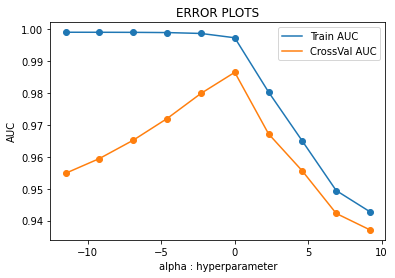

In [0]:
plt.plot(Alpha_set, Train_AUC_BOW, label='Train AUC')
plt.scatter(Alpha_set, Train_AUC_BOW)
plt.plot(Alpha_set, CrossVal_AUC_BOW, label='CrossVal AUC')
plt.scatter(Alpha_set, CrossVal_AUC_BOW)
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
optimal_alpha=alpha_set[CrossVal_AUC_BOW.index(max(CrossVal_AUC_BOW))]
print(optimal_alpha)

1


In [0]:
Classifier=BernoulliNB(alpha=optimal_alpha)
Classifier.fit(X_sm, y_sm)

BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True)

In [0]:
auc_train_bow = roc_auc_score(y_sm,Classifier.predict_proba(X_sm)[0:,], multi_class='ovr')
print ("AUC for Train set", auc_train_bow)

auc_test_bow = roc_auc_score(y_test_sm,Classifier.predict_proba(X_test_sm)[0:,], multi_class='ovr')
print ("AUc for Test set",auc_test_bow)

AUC for Train set 0.997365367404932
AUc for Test set 0.98644371687207


In [0]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(y_sm,Classifier.predict(X_sm))
print (Train_mat)

Confusion Matrix of Train Data
[[730   0   2   6   8   2   2   0   4   0]
 [  3 541   0   6   1   1   0   0 192   0]
 [  2   1 725   5   3   1   0   3   1   7]
 [  0   0   0 791   6   0   0   0   2   0]
 [  3   0   0   4 736   4   0   1   0   0]
 [  1   1   0   9   4 766   1   1   0   0]
 [  8   2   0   6   4   1 663   0   5   1]
 [  0   1   6   9   0   0   0 709   1   9]
 [  7  34   0   7   3   5   0   1 737   5]
 [  0   1   1  15  17   0   1   8   2 673]]


In [0]:
from sklearn import metrics
print(metrics.classification_report(y_test_sm,Classifier.predict(X_test_sm), target_names=df['category'].unique()))

              precision    recall  f1-score   support

    tutorial       0.94      0.82      0.88       210
     science       0.66      0.51      0.57       206
        vlog       0.94      0.96      0.95       208
        food       0.77      0.97      0.86       222
     fashion       0.91      0.97      0.93       208
      travel       0.95      0.91      0.93       218
       music       0.98      0.92      0.95       192
      movies       0.95      0.94      0.95       204
     history       0.61      0.69      0.65       222
         art       0.94      0.88      0.91       199

    accuracy                           0.86      2089
   macro avg       0.86      0.86      0.86      2089
weighted avg       0.86      0.86      0.86      2089



In [0]:
preds = Classifier.predict(X_test_sm)

In [0]:
from sklearn.metrics import accuracy_score, log_loss, f1_score
acc = accuracy_score(y_test_sm, preds)

f1 = f1_score(y_test_sm, preds, average='macro')

print ('Accuracy is : ', acc)
print ('F1 Score is :', f1)

Accuracy is :  0.8573480134035424
F1 Score is : 0.8581174733861634


In [0]:
plt.plot(c,precision, label='precision')
plt.scatter(c,precision)
plt.plot(c,recall, label='recall')
plt.scatter(c,recall)
plt.plot(c,2*(precision * recall) / (precision + recall) , label='F1 score')
plt.scatter(c,2*(precision * recall) / (precision + recall))
plt.legend()
plt.xlabel("Categories ")
plt.ylabel("Scores")
plt.title("PLOTS")

plt.show()

**TFIDF Vectorizer**

In [0]:
tf_idf = TfidfVectorizer(ngram_range=(1,2))

In [0]:
tf_idf.fit(X_train)
Train_TFIDF = tf_idf.transform(X_train)
CrossVal_TFIDF = tf_idf.transform(X_cross)
Test_TFIDF= tf_idf.transform(X_test)

In [0]:
alpha_set=[0.00001,0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0]
Train_AUC_TFIDF = []
CrossVal_AUC_TFIDF = []
for i in alpha_set:
  naive_b=MultinomialNB(alpha=i)
  naive_b.fit(Train_TFIDF, y_train)
  Train_y_pred =  naive_b.predict_proba(Train_TFIDF)[0:,]
  Train_AUC_TFIDF.append(roc_auc_score(y_train,Train_y_pred, multi_class='ovr'))
  CrossVal_y_pred =  naive_b.predict_proba(CrossVal_TFIDF)[0:,]
  CrossVal_AUC_TFIDF.append(roc_auc_score(y_cross,CrossVal_y_pred, multi_class='ovr'))

In [0]:
Alpha_set=[]
for i in range(len(alpha_set)):
  Alpha_set.append(np.math.log(alpha_set[i]))

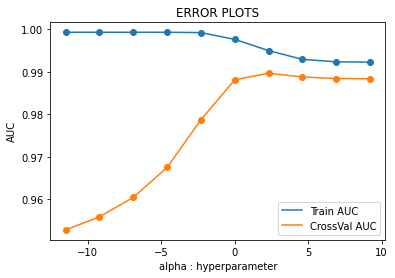

In [29]:
plt.plot(Alpha_set, Train_AUC_TFIDF, label='Train AUC')
plt.scatter(Alpha_set, Train_AUC_TFIDF)
plt.plot(Alpha_set, CrossVal_AUC_TFIDF, label='CrossVal AUC')
plt.scatter(Alpha_set, CrossVal_AUC_TFIDF)
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [30]:
optimal_alpha=alpha_set[CrossVal_AUC_TFIDF.index(max(CrossVal_AUC_TFIDF))]
print(optimal_alpha)

10.0


In [31]:
Classifier=MultinomialNB(alpha=optimal_alpha)
Classifier.fit(Train_TFIDF, y_train)

MultinomialNB(alpha=10.0, class_prior=None, fit_prior=True)

In [0]:
auc_train_tfidf = roc_auc_score(y_train,Classifier.predict_proba(Train_TFIDF)[0:,], multi_class='ovr')
print ("AUC for Train set", auc_train_tfidf)

auc_test_tfidf = roc_auc_score(y_test,Classifier.predict_proba(Test_TFIDF)[0:,], multi_class='ovr')
print ("AUc for Test set",auc_test_tfidf)

AUC for Train set 0.9949809457723076
AUc for Test set 0.9874024925192089


In [0]:
print('Confusion Matrix of Train Data')
Train_mat=confusion_matrix(y_train,Classifier.predict(Train_TFIDF))
print (Train_mat)

Confusion Matrix of Train Data
[[699   0   4   0  25   8   6   1  10   1]
 [  3 526   1   0   1   2   1   1 208   1]
 [  1   0 729   0   4   1   0   2   2   9]
 [  5   1   3 620  17  15   1   4  12   1]
 [  0   0   0   0 744   3   1   0   0   0]
 [  1   0   0   0   7 772   0   1   1   1]
 [  6   1   0   0  10   6 650   0  15   2]
 [  0   0   5   0   0   0   0 724   2   4]
 [  1  18   0   1   4   6   0   2 763   4]
 [  0   1   4   1  19   2   1  10  12 668]]


In [0]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(y_test,Classifier.predict(Test_TFIDF))
print (Test_mat)

Confusion Matrix of Test Data
[[169   2   2   2   9   5   0   3  13   5]
 [  1 108   0   1   0   3   1   0  89   3]
 [  0   0 199   0   3   2   0   1   1   2]
 [  0   1   1 166   7   5   0   3   5   0]
 [  1   0   0   0 205   1   0   0   1   0]
 [  0   0   2   0   4 207   0   2   2   1]
 [  4   0   1   1   3   1 181   1   0   0]
 [  0   1   3   0   0   0   0 197   1   2]
 [  1  44   3   3   0   3   3   1 161   3]
 [  0   1   2   0   6   1   1   4   7 177]]


In [0]:
from sklearn import metrics
print(metrics.classification_report(y_test,Classifier.predict(Test_TFIDF), target_names=df['category'].unique()))

              precision    recall  f1-score   support

    tutorial       0.96      0.80      0.88       210
     science       0.69      0.52      0.60       206
        vlog       0.93      0.96      0.95       208
        food       0.96      0.88      0.92       188
     fashion       0.86      0.99      0.92       208
      travel       0.91      0.95      0.93       218
       music       0.97      0.94      0.96       192
      movies       0.93      0.97      0.95       204
     history       0.57      0.73      0.64       222
         art       0.92      0.89      0.90       199

    accuracy                           0.86      2055
   macro avg       0.87      0.86      0.86      2055
weighted avg       0.87      0.86      0.86      2055



In [0]:
from sklearn import metrics
print(metrics.classification_report(y_train,Classifier.predict(Train_TFIDF), target_names=df['category'].unique()))

              precision    recall  f1-score   support

    tutorial       0.98      0.93      0.95       754
     science       0.96      0.71      0.81       744
        vlog       0.98      0.97      0.98       748
        food       1.00      0.91      0.95       679
     fashion       0.90      0.99      0.94       748
      travel       0.95      0.99      0.97       783
       music       0.98      0.94      0.96       690
      movies       0.97      0.99      0.98       735
     history       0.74      0.95      0.84       799
         art       0.97      0.93      0.95       718

    accuracy                           0.93      7398
   macro avg       0.94      0.93      0.93      7398
weighted avg       0.94      0.93      0.93      7398



In [33]:
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(y_test,Classifier.predict(Test_TFIDF))

f1 = f1_score(y_test,Classifier.predict(Test_TFIDF), average='macro')

print ('Accuracy is : ', acc)
print ('F1 Score is :', f1)

Accuracy is :  0.8613138686131386
F1 Score is : 0.8634607017165232


**Classification Using Description on BOW vectorizer with SMOTE**

In [0]:
X_des = df['description']

In [35]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
sss.get_n_splits(X_des, y)

10

In [0]:
for train_index, test_index in sss.split(X_des, y):
#    print("TRAIN:", train_index, "TEST:", test_index)
    X_Train, X_test = X[train_index], X[test_index]
    y_Train, y_test = y[train_index], y[test_index]  

In [0]:
X_train, X_cross, y_train, y_cross = train_test_split(X_Train, y_Train, random_state=0, stratify=y_Train, test_size=0.1)

In [0]:
count_vect = CountVectorizer()
count_vect.fit(X_train)
X_train_counts = count_vect.transform(X_train)
X_cross_counts = count_vect.transform(X_cross)
X_test_counts = count_vect.transform(X_test)

In [39]:
smote = SMOTE('minority')

X_sm, y_sm = smote.fit_sample(X_train_counts,y_train)
X_sm.shape, y_sm.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((7518, 11539), (7518,))

In [40]:
smote = SMOTE('minority')

X_test_sm, y_test_sm = smote.fit_sample(X_test_counts,y_test)
X_test_sm.shape, y_test_sm.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((2089, 11539), (2089,))

In [0]:
alpha_set=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
Train_AUC_BOW = []
CrossVal_AUC_BOW = []
for i in alpha_set:
  naive_b=MultinomialNB(alpha=i)
  naive_b.fit(X_sm, y_sm)
  Train_y_pred =  naive_b.predict_proba(X_sm)[0:,]
  Train_AUC_BOW.append(roc_auc_score(y_sm,Train_y_pred, multi_class='ovr'))
  CrossVal_y_pred =  naive_b.predict_proba(X_cross_counts)[0:,]
  CrossVal_AUC_BOW.append(roc_auc_score(y_cross,CrossVal_y_pred, multi_class='ovr'))

In [0]:
from numpy import math
Alpha_set=[]
for i in range(len(alpha_set)):
  Alpha_set.append(math.log(alpha_set[i]))

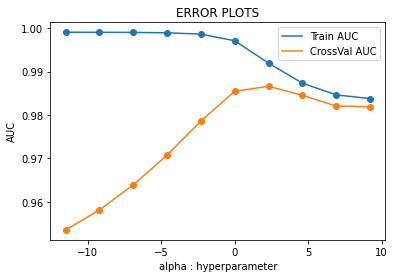

In [43]:
plt.plot(Alpha_set, Train_AUC_BOW, label='Train AUC')
plt.scatter(Alpha_set, Train_AUC_BOW)
plt.plot(Alpha_set, CrossVal_AUC_BOW, label='CrossVal AUC')
plt.scatter(Alpha_set, CrossVal_AUC_BOW)
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [44]:
optimal_alpha=alpha_set[CrossVal_AUC_BOW.index(max(CrossVal_AUC_BOW))]
print(optimal_alpha)

10


In [45]:
Classifier=MultinomialNB(alpha=optimal_alpha)
Classifier.fit(X_sm, y_sm)

MultinomialNB(alpha=10, class_prior=None, fit_prior=True)

In [0]:
auc_train_bow = roc_auc_score(y_sm,Classifier.predict_proba(X_sm)[0:,], multi_class='ovr')
print ("AUC for Train set", auc_train_bow)

auc_test_bow = roc_auc_score(y_test_sm,Classifier.predict_proba(X_test_sm)[0:,], multi_class='ovr')
print ("AUc for Test set",auc_test_bow)

AUC for Train set 0.9919454400189534
AUc for Test set 0.9867591702229394


In [0]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(y_test_sm,Classifier.predict(X_test_sm))
print (Test_mat)

Confusion Matrix of Test Data
[[171   3   3   6   9   3   2   5   1   7]
 [  1 114   0   3   2   2   2   1  78   3]
 [  0   0 198   1   3   2   0   2   0   2]
 [  0   2   1 209   6   2   0   1   1   0]
 [  1   0   0   0 204   1   0   2   0   0]
 [  0   0   2   3   4 202   1   2   1   3]
 [  4   0   1   1   2   0 184   0   0   0]
 [  0   1   3   1   0   0   0 196   0   3]
 [  1  46   2   6   0   5   4   3 151   4]
 [  0   1   2   5   6   0   1   4   0 180]]


In [0]:
c = df['category'].unique()

recall = np.diag(Test_mat) / np.sum(Test_mat, axis = 1)
precision = np.diag(Test_mat) / np.sum(Test_mat, axis = 0)

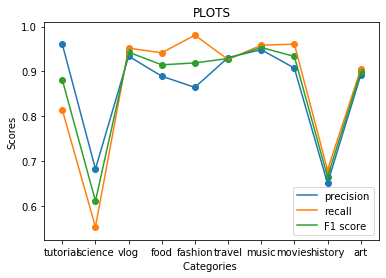

In [0]:
plt.plot(c,precision, label='precision')
plt.scatter(c,precision)
plt.plot(c,recall, label='recall')
plt.scatter(c,recall)
plt.plot(c,2*(precision * recall) / (precision + recall) , label='F1 score')
plt.scatter(c,2*(precision * recall) / (precision + recall))
plt.legend()
plt.xlabel("Categories ")
plt.ylabel("Scores")
plt.title("PLOTS")

plt.show()

In [46]:
acc = accuracy_score(y_test_sm,Classifier.predict(X_test_sm))

f1 = f1_score(y_test_sm,Classifier.predict(X_test_sm), average='macro')

print ('Accuracy is : ', acc)
print ('F1 Score is :', f1)

Accuracy is :  0.8659645763523217
F1 Score is : 0.8647041382007451


**TFIDF Vectorizer and Description**

In [0]:
tf_idf.fit(X_train)
Train_TFIDF = tf_idf.transform(X_train)
CrossVal_TFIDF = tf_idf.transform(X_cross)
Test_TFIDF= tf_idf.transform(X_test)

In [48]:
smote = SMOTE('minority')

X_sm, y_sm = smote.fit_sample(Train_TFIDF,y_train)
X_sm.shape, y_sm.shape

X_test_sm, y_test_sm = smote.fit_sample(Test_TFIDF,y_test)
X_test_sm.shape, y_test_sm.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((2089, 40715), (2089,))

In [0]:
alpha_set=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
Train_AUC_BOW = []
CrossVal_AUC_BOW = []
for i in alpha_set:
  naive_b=MultinomialNB(alpha=i)
  naive_b.fit(X_sm, y_sm)
  Train_y_pred =  naive_b.predict_proba(X_sm)[0:,]
  Train_AUC_BOW.append(roc_auc_score(y_sm,Train_y_pred, multi_class='ovr'))
  CrossVal_y_pred =  naive_b.predict_proba(CrossVal_TFIDF)[0:,]
  CrossVal_AUC_BOW.append(roc_auc_score(y_cross,CrossVal_y_pred, multi_class='ovr'))

In [0]:
from numpy import math
Alpha_set=[]
for i in range(len(alpha_set)):
  Alpha_set.append(math.log(alpha_set[i]))

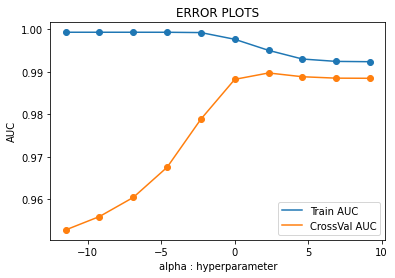

In [52]:
plt.plot(Alpha_set, Train_AUC_BOW, label='Train AUC')
plt.scatter(Alpha_set, Train_AUC_BOW)
plt.plot(Alpha_set, CrossVal_AUC_BOW, label='CrossVal AUC')
plt.scatter(Alpha_set, CrossVal_AUC_BOW)
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [53]:
optimal_alpha=alpha_set[CrossVal_AUC_BOW.index(max(CrossVal_AUC_BOW))]
print(optimal_alpha)

10


In [54]:
Classifier=MultinomialNB(alpha=optimal_alpha)
Classifier.fit(X_sm, y_sm)

MultinomialNB(alpha=10, class_prior=None, fit_prior=True)

In [55]:
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(y_test_sm,Classifier.predict(X_test_sm))
print (Test_mat)

Confusion Matrix of Test Data
[[169   2   2  14   8   4   0   3   4   4]
 [  1 108   0   6   0   2   1   0  85   3]
 [  0   0 199   1   3   2   0   1   0   2]
 [  0   0   1 208   8   2   0   0   3   0]
 [  1   0   0   1 205   1   0   0   0   0]
 [  0   0   2   4   4 204   0   1   2   1]
 [  4   0   1   2   3   1 180   1   0   0]
 [  0   0   3   2   0   0   0 197   0   2]
 [  1  43   2   8   0   2   3   1 159   3]
 [  0   1   2   4   6   1   1   4   3 177]]


In [56]:
acc = accuracy_score(y_test_sm,Classifier.predict(X_test_sm))

f1 = f1_score(y_test_sm,Classifier.predict(X_test_sm), average='macro')

print ('Accuracy is : ', acc)
print ('F1 Score is :', f1)

Accuracy is :  0.8645284825275251
F1 Score is : 0.8641470058691219


In [0]:
from prettytable import PrettyTable

In [60]:
x = PrettyTable()

x.field_names = ["VECTORIZER", "SAMPLING", "HYPER PARAMETER", "ACCURACY", "F1 SCORE"]

x.add_row(["BOW","NORMAL",10,0.8647,0.8560])
x.add_row(["BOW","SMOTE",10,0.8632,0.8627])
x.add_row(["TFIDF","NORMAL",10,0.86131,0.86346])
x.add_row(["TFIDF","SMOTE",10,0.86587,0.87656])
x.add_row(["DESCRIPTION - BOW","SMOTE",10,0.86596,0.86470])
x.add_row(["DESCRIPTION- TFIDF","SMOTE",10,0.86453,0.86415])
x.add_row(["BOW+BERNOULLI-NB","NORMAL",1,0.85374,0.85812])

print(x)

+--------------------+----------+-----------------+----------+----------+
|     VECTORIZER     | SAMPLING | HYPER PARAMETER | ACCURACY | F1 SCORE |
+--------------------+----------+-----------------+----------+----------+
|        BOW         |  NORMAL  |        10       |  0.8647  |  0.856   |
|        BOW         |  SMOTE   |        10       |  0.8632  |  0.8627  |
|       TFIDF        |  NORMAL  |        10       | 0.86131  | 0.86346  |
|       TFIDF        |  SMOTE   |        10       | 0.86587  | 0.87656  |
| DESCRIPTION - BOW  |  SMOTE   |        10       | 0.86596  |  0.8647  |
| DESCRIPTION- TFIDF |  SMOTE   |        10       | 0.86453  | 0.86415  |
|  BOW+BERNOULLI-NB  |  NORMAL  |        1        | 0.85374  | 0.85812  |
+--------------------+----------+-----------------+----------+----------+




1.   Prediction on Title using Tf-Idf with SMOTE gives the best accuracy, F1 score is also the best for the given model
2.   Prediction on Description using BOW on SMOTE gives the best the accuracy and F1- Score.


*   AUC curves, Confusion Matrices, Classification Reports and Categorical error-rate has been plotted for each of the models.




